In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy, mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf
import random

2023-03-08 14:17:28.493454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = np.load("mutations_bytemask.npz")
max_len = 5000
X, Y = data['x'], data['y']

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1)                 


print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)
print ('Test:', test_x.shape, test_y.shape)

Training: (9029, 625, 64) (9029, 625, 64)
Validation: (1115, 625, 64) (1115, 625, 64)
Test: (1004, 625, 64) (1004, 625, 64)


In [13]:
X.shape

(11148, 625, 64)

In [3]:
tf.config.list_physical_devices('GPU')

2023-03-08 14:17:57.936027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-03-08 14:17:57.950260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 14:17:57.950429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Base model
model = Sequential()
model.add(LSTM(64, input_shape=train_x[0].shape, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(LSTM(64, input_shape=train_x[0].shape, return_sequences=True))
model.summary()
adam = Adam(learning_rate=0.00005)
model.compile(optimizer=adam, loss=mean_squared_error)

2023-03-08 14:17:57.960635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:17:57.961996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 14:17:57.962163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 14:17:57.962286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 625, 64)           33024     
                                                                 
 batch_normalization (BatchN  (None, 625, 64)          256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 625, 100)          6500      
                                                                 
 lstm_1 (LSTM)               (None, 625, 64)           42240     
                                                                 
Total params: 82,020
Trainable params: 81,892
Non-trainable params: 128
_________________________________________________________________


In [5]:
es = EarlyStopping(monitor='val_loss', patience=15)

filepath = 'best_model_lstm_checkpoint.h5'

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = model.fit(train_x, train_y,
                    batch_size=32,
                    epochs=400,
                    validation_data=(val_x, val_y),
                    callbacks =[es, checkpoint])

Epoch 1/400


2023-03-08 14:18:05.204014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-08 14:18:05.333901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


283/283 [==============================] - ETA: 0s - loss: 0.0058
Epoch 1: val_loss improved from inf to 0.00513, saving model to best_model_lstm_checkpoint.h5
283/283 [==============================] - 13s 36ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 2/400
283/283 [==============================] - ETA: 0s - loss: 0.0043
Epoch 2: val_loss improved from 0.00513 to 0.00504, saving model to best_model_lstm_checkpoint.h5
283/283 [==============================] - 9s 33ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 3/400
283/283 [==============================] - ETA: 0s - loss: 0.0041
Epoch 3: val_loss did not improve from 0.00504
283/283 [==============================] - 10s 34ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 4/400
283/283 [==============================] - ETA: 0s - loss: 0.0040
Epoch 4: val_loss did not improve from 0.00504
283/283 [==============================] - 9s 33ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 5/400
283/283 [==============================]

In [6]:
from keras.models import load_model
model.load_weights("best_model_lstm_checkpoint.h5")
test_loss = model.evaluate(test_x, test_y)
test_loss

32/32 [==============================] - 0s 13ms/step - loss: 0.0045


0.004520630929619074

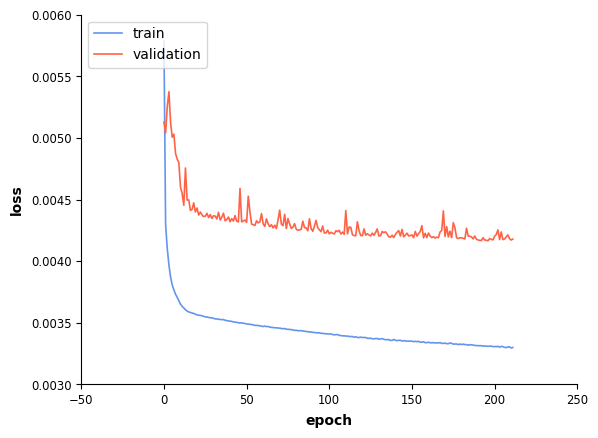

In [14]:
plt.style.use('apa')
# summarize history for loss
plt.plot(history.history['loss'], color='cornflowerblue',alpha=1)
plt.plot(history.history['val_loss'],color='tomato',alpha=1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()